<a href="https://colab.research.google.com/github/timsetsfire/odsc-ml-drum/blob/main/Colab%20-%20Keras%20on%20GPU%20with%20DRUM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras, Drum, and MLOps Agent

 The point of this Notebook is to leverage GPUs for inference scoring for DNN models served up via [DRUM](www.github.com/datarobot/datarobot-user-models) all while monitoring said models via DataRobot MLOps Monitoring Agents 

## Setup

In order to walk through this notebook, we must set up the environment.  

This will entail
* installing `git-lfs`
* cloning `datarobot/datarobot-user-models` repo
* installing a bunch of python libraries
* for the prediction server, simplest route is to leverage flask.  If you choose to use uswgi + nginx, you will have to modify the uswgi ini file.
* turn on gpu (go to Edit -> Notebook Settings -> Hardware accelerator -> GPU)

For monitoring the model with DataRobot MLOps Agents, 
1. You need a DataRobot account and API key.  Sign up at: https://www.datarobot.com/lp/trial/ - for referral, put down Tim Whittaker
2. Get the MLOps agent tar file, found under Developer Tools in the DataRobot App (Click on the far right orange person icon)
3. Copy the MLOps agent tar file and put it into your google drive

if you are just reviewing this notebook, jump ahead to [Test Scoring with Keras Model](https://colab.research.google.com/drive/1yGQgvz1tDQMwL0gLD-7HlDSEVV3Kk8R1#)

### Install `nginx` and `git-lfs`

In [2]:
!sudo apt-get install nginx > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 14.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [3]:
!sudo apt-get install git-lfs > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


### Install required packages to for DRUM to use Keras models

this will utilize `drum==1.4.15`

In [1]:
!pip install datarobot-drum -q

     |████████████████████████████████| 8.7MB 7.4MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 276kB 54.1MB/s 
     |████████████████████████████████| 204kB 58.3MB/s 
     |████████████████████████████████| 17.7MB 205kB/s 
     |████████████████████████████████| 153kB 50.5MB/s 
     |████████████████████████████████| 788kB 53.2MB/s 
     |████████████████████████████████| 112kB 60.4MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 204kB 40.8MB/s 
     |████████████████████████████████| 808kB 56.8MB/s 
     |████████████████████████████████| 552kB 57.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [6]:
!git clone https://github.com/datarobot/datarobot-user-models.git

Cloning into 'datarobot-user-models'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 6103 (delta 147), reused 157 (delta 98), pack-reused 5845
Receiving objects: 100% (6103/6103), 120.70 MiB | 35.16 MiB/s, done.
Resolving deltas: 100% (4029/4029), done.


In [7]:
# !pip install -q --upgrade-strategy eager --no-cache-dir --prefer-binary -r /content/datarobot-user-models/public_dropin_environments/python3_keras/dr_requirements.txt
!pip install -q -r /content/datarobot-user-models/public_dropin_environments/python3_keras/requirements.txt --no-cache-dir
!pip install -q requests_futures;

     |████████████████████████████████| 516.2MB 1.3MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 10.5MB 61.9MB/s 
     |████████████████████████████████| 6.9MB 57.0MB/s 
     |████████████████████████████████| 2.1MB 53.6MB/s 
     |████████████████████████████████| 460kB 54.7MB/s 
     |████████████████████████████████| 3.0MB 56.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


# __Restart runtime!!__

If you don't do this nothign will work

In [8]:
!drum --version

drum 1.4.15


In [9]:
## load the model and review
import sys
sys.path.append('/content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib')
from model_utils import *
pipeline = deserialize_estimator_pipeline("/content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib")

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
pipeline.steps[-1][1].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1281      
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


# Test scoring with Keras model with DRUM
<a id="setup_complete"></a>

Next snippet is to test scoring.  Want to review the log and ensure that a gpu device is being attached to aid the dnn inference.  

With GPUs takes about 10 seconds, without takes much longer

In [11]:
!drum score --code-dir /content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib \\
--input /content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv --target-type binary --positive-class-label dog --negative-class-label cat --verbose

Detected score mode
Detected /content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib/custom.py .. trying to load hooks
2021-02-19 13:56:24,495 WARNING tensorflow:  `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
2021-02-19 13:56:24.513691: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-02-19 13:56:24.519834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-19 13:56:24.520408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-19 13:56:24

# Start the inference server locally

## If using uwsgi + nginx

Modify uwsgi config

When uswgi workers are instantiated, the ini file contains all the environment variables the workers will use when serving up the model.  To leverage GPU, you will need to update 

`/usr/local/lib/python3.6/dist-packages/mlpiper/components/restful/uwsgi_ini_template.py`

you should be able to click the link above to open file editor. 

The following cell will format all the environment variables so that you can copy the contents from the output of this cell and paste into the ini in the appropriate section.  Look for `# environment variables` around line 44

Also you will need to __delete__ `CUDA_VISIBLE_DEVICES` from the ini file

Mostly likely don't need all the environment variables listed below, but I'm too lazy to find out.  

In [12]:
import os
## the output of this cell should be copy and pasted into the
## uwsgi ini file
## /usr/local/lib/python3.6/dist-packages/mlpiper/components/restful/uwsgi_ini_template.py
## additionaly delete CUDA_VISIBLE_DEVICES variable the ini file
for k,v in os.environ.items():
  if k not in ["DATALAB_SETTINGS_OVERRIDES", "PYTHONPATH"]:
    print("env = {}={}".format(k,v))

env = NO_GCE_CHECK=True
env = GCS_READ_CACHE_BLOCK_SIZE_MB=16
env = CLOUDSDK_CONFIG=/content/.config
env = __EGL_VENDOR_LIBRARY_DIRS=/usr/lib64-nvidia:/usr/share/glvnd/egl_vendor.d/
env = CUDA_VERSION=10.1.243
env = PATH=/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin
env = HOME=/root
env = LD_LIBRARY_PATH=/usr/lib64-nvidia
env = LANG=en_US.UTF-8
env = SHELL=/bin/bash
env = LIBRARY_PATH=/usr/local/cuda/lib64/stubs
env = CUDA_PKG_VERSION=10-1=10.1.243-1
env = SHLVL=0
env = GCE_METADATA_TIMEOUT=0
env = NCCL_VERSION=2.8.3
env = NVIDIA_VISIBLE_DEVICES=all
env = DEBIAN_FRONTEND=noninteractive
env = CUDNN_VERSION=7.6.5.32
env = LAST_FORCED_REBUILD=20210203
env = JPY_PARENT_PID=50
env = ENV=/root/.bashrc
env = GLIBCXX_FORCE_NEW=1
env = NVIDIA_DRIVER_CAPABILITIES=compute,utility
env = TF_FORCE_GPU_ALLOW_GROWTH=true
env = LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4
env = NVIDIA_

## Start the Server

There are a few keras examples available in the `DRUM` repo.  In what follows, you can eithe ruse the cat dog image classification example, or a keras models which was training on the boston housing prices dataset.

The example which follows is running on the cat dog classification model

In [13]:
import subprocess
import requests
import pandas as pd
from io import BytesIO
import yaml
import time

In [14]:
!sudo service nginx status

 * nginx is not running


## uSWGI + NGINX vs Flask

Starting the server, we'll use `subprocess.Popen`.  Take note below in the `run_server` variable.  If nyou want to use nginx, you should have updated the uwsgi ini file.  Also, you will provide the `--production` and `--max-workers` arguments.  If you don't care and didn't update uwsgi ini, make sure those arguments are commented out and you will leverage flask to serve up the model.  

In [15]:
%%sh
mkdir -p /tmp/ta

In [26]:

del os.environ["MONITOR"]
del os.environ["DEPLOYMENT_ID"]
del os.environ["MODEL_ID"]
del os.environ["MONITOR_SETTINGS"]

In [31]:
run_server = ["drum",
              "server",
              "--code-dir","/content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib", 
              "--address", "0.0.0.0:1234", 
              # "--production",   
              # "--max-workers", "10",
              "--target-type", "binary", 
              "--positive-class-label", "dog", 
              "--negative-class-label", "cat",
              "--show-perf",
              "--logging-level", "info",
              "--show-stacktrace",
              # "--monitor",
              "--verbose"
              ]
server = subprocess.Popen(run_server, stdout=subprocess.PIPE)

In [18]:
!sudo service nginx status

 * nginx is not running


In [32]:
# server.terminate()
# server.stdout.readlines()

In [ ]:
# !nginx -s stop

## Ping the Server to make sure it is running

In [33]:
## confirm the server is running
time.sleep(5) ## snoozing before pinging the server to give it time to actually start
print('check status')
requests.request("GET", "http://0.0.0.0:1234/").content

check status


b'{"message":"OK"}\n'

In [ ]:
# ## if you use flask this will return nginx is not running
# !sudo service nginx status

In [34]:
# df = pd.read_csv('/content/datarobot-user-models/tests/testdata/boston_housing_inference.csv')
df = pd.read_csv('/content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv')

In the cats and dogs dataset, the images have already been encoded.  If you can imagine having a pandas dataframe where each record is a file path, the following would be applied to encode the image.  
```
def convert_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string

df["image"] = df["path"].apply(lambda x: convert_to_base64(x))
```

In [35]:
def score(data):
  b_buf = BytesIO()
  b_buf.write(data.to_csv(index=False).encode("utf-8"))
  b_buf.seek(0)
  
  url = "http://localhost:1234/predict/"
  files = [
    ('X', b_buf)
    # ('X', open('/content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv', 'rb'))
  ]
  response = requests.request("POST", url, files = files, timeout=None, verify=False)

  return response

## Send data to server for inference

In [36]:
df[["image"]].head()

image
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...

In [37]:
from PIL import Image
import io
import matplotlib.pyplot as plt
import base64
import numpy as np

# Take in base64 string and return a numpy image array
def stringToRGB(base64_string):
    imgdata = base64.b64decode(base64_string)
    image = Image.open(io.BytesIO(imgdata))
    return np.array(image)

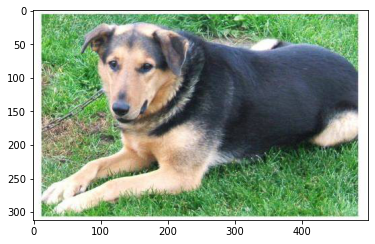

In [38]:
plt.imshow(stringToRGB(df["image"].iloc[0]))

In [39]:
# %%timeit
# start_time = time.time()
score(df).json()["predictions"][0:5] ## score entire dataset but only show first 5 records
# end_time = time.time()
# print(end_time - start_time)

[{'cat': 0.466139555, 'dog': 0.533860445},
 {'cat': 0.4465075135, 'dog': 0.5534924865},
 {'cat': 0.4246357083, 'dog': 0.5753642917},
 {'cat': 0.4418278933, 'dog': 0.5581721067},
 {'cat': 0.4134984016, 'dog': 0.5865015984}]

## If using NGINX

You can make concurrent requests to the prediction server

Obviously, `--max-workers` should be set.  

In [40]:
# from requests_futures.sessions import FuturesSession
# from tqdm import notebook
# import math
# from io import StringIO

In [41]:
# concurrency = 10
# sample_size = 20
# session = FuturesSession(max_workers=concurrency)

In [42]:
# %%timeit
# # start_time = time.time()
# responses = []
# results = []
# results_df = pd.DataFrame()

# for i in notebook.tqdm(range(math.ceil(len(df)/sample_size))):
#     start_index = i * sample_size
#     end_index   = start_index + sample_size - 1
#     data = df.iloc[start_index:end_index]
#     b_buf = BytesIO()
#     b_buf.write(data.to_csv(index=False, header=True).encode("utf-8"))
#     b_buf.seek(0)  
#     url = "http://localhost:6789/predict/"
#     files = [
#       ('X', b_buf)
#       # ('X', open('/content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv', 'rb'))
#     ]
#     responses.append(session.post(url, files=files))
    
# for future in notebook.tqdm(responses):
#     resp = future.result().json()
#     results.append(resp)

# # end_time = time.time()
# # print(end_time - start_time)

In [43]:
# server.terminate()
# server.stdout.readlines()

In [44]:
!sudo service nginx status

 * nginx is not running


## Shutdown inference server

In [45]:
## this endpoint is only available for non production server
url = "http://0.0.0.0:1234/shutdown/"

response = requests.request("POST", url)

print(response.text.encode('utf8'))

b'Server shutting down...'


In [ ]:
## run this if you using nginx
# !nginx -s stop

nginx: [error] open() "/run/nginx.pid" failed (2: No such file or directory)


# Adding Monitoring with MLOps Monitoring Agents

## DataRobot API Token

I keep my api token in a config yaml located in my gdrive.  This will be used to connect to DataRobot and create the external deployment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cp -av '/content/gdrive/My Drive/agent/config.yaml' /content/

In [ ]:
# os.environ["MONITOR"] = "False"
# os.environ["DEPLOYMENT_ID"] = "HOLD"
# os.environ["MODEL_ID"] = "HOLD"
# os.environ["MONITOR_SETTINGS"] = "spooler_type=filesystem;directory=/tmp/ta;max_files=5;file_max_size=1045876000"

In [ ]:
# %cp -av ,'/content/gdrive/My Drive/agent/datarobot-mlops-agent-6.2.4-399.tar.gz' /content/
# !tar -xf /content/datarobot-mlops-agent-6.2.4-399.tar.gz ##If you have a newer version of the agent, this could be different filename
!tar -xvf /content/datarobot-mlops-agent-6.2.4-399.tar.gz > /dev/null ##If you have gz zipped version#
%cd /content/datarobot-mlops-agent-6.2.4/
!pip install -q lib/datarobot_mlops-6.2.4-py2.py3-none-any.whl ##If you have a newer version of the agent, this could be different filename



/content/datarobot-mlops-agent-6.2.4
     |████████████████████████████████| 112kB 2.7MB/s 
     |████████████████████████████████| 133kB 8.3MB/s 
     |████████████████████████████████| 204kB 7.6MB/s 
     |████████████████████████████████| 5.9MB 8.0MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 552kB 32.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
import yaml
with open(r'/content/gdrive/My Drive/agent/config.yaml') as file:
    auth_detail = yaml.load(file)

In [11]:

auth_detail

{'DATAROBOT_API_TOKEN': 'L-KEWy2boF5520IYONK096R-XzHOuVsk',
 'DATAROBOT_ENDPOINT': 'https://app.datarobot.com/api/v2',
 'DATAROBOT_USERNAME': 'timothy.whittaker@datarobot.com'}

In [15]:
import datarobot as dr
token = "token"
endpoint = "https://app2.datarobot.com"
## connect to DataRobot platform with python client. 
client = dr.Client(auth_detail["DATAROBOT_API_TOKEN"], auth_detail["DATAROBOT_ENDPOINT"])
mlops_agents_tb = client.get("mlopsInstaller")
with open("mlops-agent.tar.gz", "wb") as f:
    f.write(mlops_agents_tb.content)

In [18]:
!tar -xf mlops-agent.tar.gz -C .

In [21]:
import os
agents_path = [f for f in os.listdir() if "datarobot" in f].pop()

In [22]:
agents_path

'datarobot_mlops_package-7.0.5'

In [24]:
with open(os.path.join(agents_path, "conf/mlops.agent.conf.yaml")) as file:
    documents = yaml.load(file)
documents

{'agentMaxAggregatedRecords': 500,
 'agentMaxRecordsTask': 100,
 'agentPendingRecordsTimeoutMs': 2500,
 'agentThreadPoolSize': 4,
 'apiToken': 'FILL_IN_HERE',
 'channelConfigs': [{'details': {'directory': '/tmp/ta', 'name': 'filesystem'},
   'type': 'FS_SPOOL'}],
 'dryRun': False,
 'httpRetry': 1,
 'httpTimeout': 30000,
 'logPath': './logs/mlops.agent.log',
 'mlopsUrl': 'https://<DATAROBOT_HOST>',
 'runOnce': False,
 'statsPath': '/tmp/tracking-agent-stats.json',
 'verifySSL': True}

In [25]:
# Set your DR host:
documents['mlopsUrl'] = "https://app.datarobot.com"
# Set your API token
documents['apiToken'] = auth_detail["DATAROBOT_API_TOKEN"] 
with open(os.path.join(agents_path, "conf/mlops.agent.conf.yaml"), "w") as f:
    yaml.dump(documents, f)

**bold text**## Create the mlops model deployement in DR

In [26]:
model_info = {
        "name": "Cats or Dog Keras model on colab (GPUS)",
        "modelDescription": {
            "description": "Classification on images as either Cat or Dog"
        },
        "target": {
            "type": "Binary",
            "name": "class",
            "classNames": ["dogs", "cats"],
            "predictionThreshold": 0.5
        }
}


In [27]:
TRAINING_DATA = '/content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv'

In [ ]:
DEPLOYMENT_NAME="Cats or Dog Keras model on colab (GPUS)"
from datarobot.mlops.mlops import MLOps
from datarobot.mlops.common.enums import OutputType
from datarobot.mlops.connected.client import MLOpsClient
from datarobot.mlops.common.exception import DRConnectedException
from datarobot.mlops.constants import Constants


# Read the mlops connection info from the provided example 
with open('/content/datarobot-mlops-agent-6.2.4/conf/mlops.agent.conf.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    agent_yaml_dict = yaml.load(file, Loader=yaml.Loader) ##CHANGE##

MLOPS_URL = agent_yaml_dict['mlopsUrl']
API_TOKEN = agent_yaml_dict['apiToken']

# Create connected client
mlops_connected_client = MLOpsClient(MLOPS_URL, API_TOKEN)

# Add training_data to model configuration
print("Uploading training data - {}. This may take some time...".format(TRAINING_DATA))
dataset_id = mlops_connected_client.upload_dataset(TRAINING_DATA)
print("Training dataset uploaded. Catalog ID {}.".format(dataset_id))
model_info["datasets"] = {"trainingDataCatalogId": dataset_id}

# Create the model package
print('Create model package')
model_pkg_id = mlops_connected_client.create_model_package(model_info)
model_pkg = mlops_connected_client.get_model_package(model_pkg_id)
model_id = model_pkg["modelId"]

# Deploy the model package
print('Deploy model package')
deployment_id = mlops_connected_client.deploy_model_package(model_pkg["id"],
                                                            DEPLOYMENT_NAME)

# Enable data drift tracking
print('Enable feature drift')
enable_feature_drift = TRAINING_DATA is not None
mlops_connected_client.update_deployment_settings(deployment_id, target_drift=True,
                                                  feature_drift=enable_feature_drift)
_ = mlops_connected_client.get_deployment_settings(deployment_id)

print("\nDone.")
print("DEPLOYMENT_ID=%s, MODEL_ID=%s" % (deployment_id, model_id))

DEPLOYMENT_ID = deployment_id
MODEL_ID = model_id

Uploading training data - /content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv. This may take some time...
Training dataset uploaded. Catalog ID 5f749748835c6d0048962e5e.
Create model package
Deploy model package
Enable feature drift

Done.
DEPLOYMENT_ID=5f74977bd6e71600517b1a25, MODEL_ID=5f749778d6e716017a38d9b6


## Set some environment variables for monitoring

In [ ]:
import os
os.environ["MONITOR"] = "True"
os.environ["DEPLOYMENT_ID"] = deployment_id
os.environ["MODEL_ID"] = model_id
os.environ["MONITOR_SETTINGS"] = "spooler_type=filesystem;directory=/tmp/ta;max_files=5;file_max_size=1045876000"

## Start agents service

In [ ]:
# Start
!/content/datarobot-mlops-agent-6.2.4/bin/start-agent.sh

INFO: AGENT_CONFIG_YAML=/content/datarobot-mlops-agent-6.2.4/conf/mlops.agent.conf.yaml
INFO: AGENT_LOG_PROPERTIES=/content/datarobot-mlops-agent-6.2.4/conf/mlops.log4j2.properties
INFO: AGENT_JVM_OPT=-Xmx1G
INFO: AGENT_JAR_PATH=/content/datarobot-mlops-agent-6.2.4/lib/mlops-agent-6.2.4.jar
INFO: AGENT_LOG_PATH=/content/datarobot-mlops-agent-6.2.4/logs/mlops.agent.log

Starting MLOps-Agent


DataRobot MLOps-Agent is running.


## Test scoring with drum + Monitoring agents!

In [ ]:
import datarobot as dr
client = dr.Client(auth_detail["DATAROBOT_API_TOKEN"], auth_detail["DATAROBOT_ENDPOINT"])
deployment = dr.Deployment.get(deployment_id)
deployment
deployment.get_service_stats()

DataError: ignored

In [ ]:
!drum score --code-dir /content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib \\
--input /content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv \\
--positive-class-label dogs --negative-class-label cats --monitor

Using TensorFlow backend.
2020-09-30 14:37:39.569268: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-09-30 14:37:39.573555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-30 14:37:39.574572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-09-30 14:37:39.574933: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-09-30 14:37:39.578690: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-30 14:37:39.581958: I tensorflow/strea

In [ ]:
time.sleep(5)
service_stats = deployment.get_service_stats()
service_stats.metrics

{'cacheHitRatio': 0,
 'executionTime': 5485.60261726379,
 'medianLoad': 0,
 'numConsumers': 1,
 'peakLoad': 1,
 'responseTime': 0,
 'serverErrorRate': 0,
 'slowRequests': 0,
 'totalPredictions': 200,
 'totalRequests': 1,
 'userErrorRate': 0}

## Start the Prediction Server

In [ ]:
server = subprocess.Popen(run_server)

In [ ]:
## not necessary to read in data again, but
# df = pd.read_csv("/content/datarobot-user-models/tests/testdata/boston_housing_inference.csv")
import pandas as pd
df = pd.read_csv("/content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv")

In [ ]:
# status
!/content/datarobot-mlops-agent-6.2.4/bin/status-agent.sh

DataRobot MLOps-Agent is running as a service.


In [ ]:
score(df).json()["predictions"][0:5] 

[0.5476985574, 0.5097822547, 0.5199275017, 0.504788518, 0.4424930513]

In [ ]:
time.sleep(5)
service_stats = deployment.get_service_stats()
service_stats.metrics

{'cacheHitRatio': 0,
 'executionTime': 4992.00677871704,
 'medianLoad': 0,
 'numConsumers': 1,
 'peakLoad': 4,
 'responseTime': 0,
 'serverErrorRate': 0,
 'slowRequests': 0,
 'totalPredictions': 3200,
 'totalRequests': 16,
 'userErrorRate': 0}